## Aplicando ResNet

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
df1 = pd.read_excel('wclassesFiltered.xlsx')

In [3]:
for img_p in range(df1.shape[0]):
    img_path = df1.iloc[img_p, 1]
    if "Ã¢Â\xa0" in img_path:
        img_path = img_path.replace('Ã¢Â', '\u00E2')
        temp_path = img_path.replace('\u00E2', 'a') 
        df1.iat[img_p, 1] = temp_path
    df1.iat[img_p, 4] = df1.iloc[img_p, 4]-140

In [4]:
df1.loc[:,'style'] = df1['style'].astype(str)

In [5]:
train = df1.sample(frac=0.8,random_state=200)
test = df1.drop(train.index)

In [6]:
target_size=(256,256) # set the size of the images
color_mode='rgb' # set the type of image
class_mode= 'categorical' # set the class mode
batch_size=64  # set the batch size
subset='training' # set to 'training', or 'valiatiom' or leave as None

train_gen = ImageDataGenerator(validation_split=0.2, preprocessing_function=tf.keras.applications.resnet.preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

train_imgs= train_gen.flow_from_dataframe(dataframe=train, 
          x_col='file',
          y_col='style',
          target_size=target_size,color_mode=color_mode,
          class_mode=class_mode, batch_size=batch_size,shuffle=True, seed=123,
          subset='training')
val_imgs= train_gen.flow_from_dataframe(dataframe=train, 
          x_col='file',
          y_col='style',
          target_size=target_size,color_mode=color_mode,
          class_mode=class_mode, batch_size=batch_size,shuffle=True, seed=123,
          subset="validation")
test_imgs= test_gen.flow_from_dataframe(dataframe=test, 
          x_col='file',
          y_col='style',
          target_size=target_size,color_mode=color_mode,
          class_mode=class_mode, batch_size=batch_size,shuffle=True, seed=123,
          subset='training')

Found 5120 validated image filenames belonging to 9 classes.
Found 1280 validated image filenames belonging to 9 classes.
Found 1600 validated image filenames belonging to 9 classes.


ResNet é uma ANN (artificial neural network), variante da HigwayNet (https://en.wikipedia.org/wiki/Highway_network). Pode possuir centenas de camadas, sendo muito mais profunda do que redes neurais anteriores. São usados conexões de salto ou atalhos ​​para saltar sobre algumas camadas. Modelos ResNet típicos são implementados com saltos de camada dupla ou tripla que contêm não linearidades (ReLU) e normalização de lote no meio. Modelos com vários saltos paralelos são referidos como DenseNets.

In [7]:
base_model = tf.keras.applications.ResNet152(weights = 'imagenet', include_top = False, input_shape = (256,256,3))
for layer in base_model.layers:
  layer.trainable = False

In [8]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(9, activation = 'softmax')(x)

In [9]:
head_model = Model(inputs = base_model.input, outputs = predictions)
head_model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

In [10]:
history = head_model.fit(train_imgs, epochs=40, validation_data=(val_imgs))

Epoch 1/40
80/80 [==============================] - 41s 373ms/step - loss: 17.8599 - accuracy: 0.7213 - val_loss: 0.7501 - val_accuracy: 0.8352
Epoch 2/40
80/80 [==============================] - 27s 332ms/step - loss: 0.1891 - accuracy: 0.9523 - val_loss: 0.6647 - val_accuracy: 0.8625
Epoch 3/40
80/80 [==============================] - 27s 332ms/step - loss: 0.0504 - accuracy: 0.9932 - val_loss: 0.7325 - val_accuracy: 0.8648
Epoch 4/40
80/80 [==============================] - 27s 332ms/step - loss: 0.0365 - accuracy: 0.9971 - val_loss: 0.6762 - val_accuracy: 0.8781
Epoch 5/40
80/80 [==============================] - 27s 333ms/step - loss: 0.0299 - accuracy: 0.9979 - val_loss: 0.6726 - val_accuracy: 0.8773
Epoch 6/40
80/80 [==============================] - 27s 336ms/step - loss: 0.0333 - accuracy: 0.9975 - val_loss: 0.7721 - val_accuracy: 0.8656
Epoch 7/40
80/80 [==============================] - 28s 344ms/step - loss: 0.0286 - accuracy: 0.9975 - val_loss: 0.7394 - val_accuracy: 0.878

25/25 - 8s - loss: 0.8347 - accuracy: 0.8587 - 8s/epoch - 308ms/step


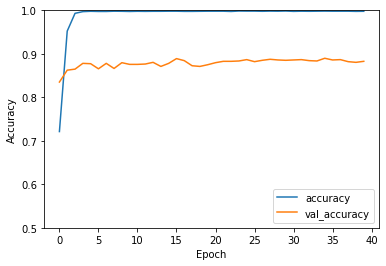

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = head_model.evaluate(test_imgs, verbose=2)

In [ ]:
#head_model.evaluate(x_test, y_test)